In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('fact_train_test.csv', delimiter=';')

In [6]:
df['period'] = pd.to_datetime(df['period'])
df_ = df.period.value_counts()
ddf = df_.to_frame().sort_values(by='period').reset_index()

In [7]:
date_time = pd.to_datetime(ddf.pop('period'), format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
month = 30*day
year = (365.2425)*day

ddf['month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
ddf['month cos'] = np.cos(timestamp_s * (2 * np.pi / month))
ddf['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
ddf['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of month signal')

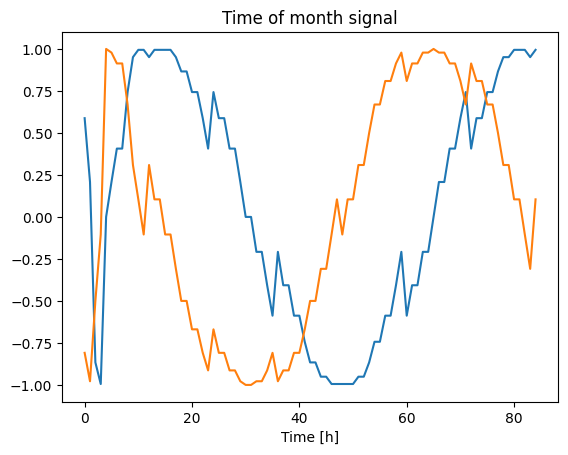

In [8]:
plt.plot(np.array(ddf['month sin']))
plt.plot(np.array(ddf['month cos']))
plt.xlabel('Time [h]')
plt.title('Time of month signal')

In [9]:
ddf_copy = ddf.iloc[9:,:]

In [10]:
window_size = 5
index_array = []
for j in range(len(ddf_copy.columns)):
    for i in range(window_size):
        column_name = ddf_copy.columns[j] + ' ' + str(i)
        index_array.append(column_name)
ddf_name = pd.DataFrame(columns = index_array)
print(ddf_name)
num_col_new = len(ddf_copy.columns)
num_row_new = ddf_copy.shape[0]
num_col_dfr = len(ddf_name.columns)
num_row_dfr = ddf_copy.shape[0]
print(num_row_dfr)
array = np.array([])
for i in range(num_row_dfr- window_size + 1):
    for j in range(num_col_new):
        array = np.hstack((array,list(ddf_copy.iloc[i:i+window_size,j])))
        print(array)
array = array.reshape((num_row_new - window_size + 1, num_col_dfr))
print(array.shape)
ddf_series = pd.DataFrame(array)
ddf_series.columns = list(ddf_name.columns)

Empty DataFrame
Columns: [count 0, count 1, count 2, count 3, count 4, month sin 0, month sin 1, month sin 2, month sin 3, month sin 4, month cos 0, month cos 1, month cos 2, month cos 3, month cos 4, Year sin 0, Year sin 1, Year sin 2, Year sin 3, Year sin 4, Year cos 0, Year cos 1, Year cos 2, Year cos 3, Year cos 4]
Index: []

[0 rows x 25 columns]
76
[ 2455. 42282. 58302. 54447. 54542.]
[2.45500000e+03 4.22820000e+04 5.83020000e+04 5.44470000e+04
 5.45420000e+04 9.51056516e-01 9.94521895e-01 9.94521895e-01
 9.51056516e-01 9.94521895e-01]
[ 2.45500000e+03  4.22820000e+04  5.83020000e+04  5.44470000e+04
  5.45420000e+04  9.51056516e-01  9.94521895e-01  9.94521895e-01
  9.51056516e-01  9.94521895e-01  3.09016994e-01  1.04528463e-01
 -1.04528463e-01  3.09016994e-01  1.04528463e-01]
[ 2.45500000e+03  4.22820000e+04  5.83020000e+04  5.44470000e+04
  5.45420000e+04  9.51056516e-01  9.94521895e-01  9.94521895e-01
  9.51056516e-01  9.94521895e-01  3.09016994e-01  1.04528463e-01
 -1.04528463

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression as lr
from sklearn.svm import SVR
from sklearn.metrics import r2_score as r2, mean_squared_error as mse, mean_absolute_error as mae
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
#cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
X = ddf_series[['count 0', 'count 1', 'count 2', 'count 3', 'month sin 0',
       'month sin 1', 'month sin 2', 'month sin 3', 'month sin 4',
       'month cos 0', 'month cos 1', 'month cos 2', 'month cos 3',
       'month cos 4', 'Year sin 0', 'Year sin 1', 'Year sin 2', 'Year sin 3',
       'Year sin 4', 'Year cos 0', 'Year cos 1', 'Year cos 2', 'Year cos 3',
       'Year cos 4']]
y = ddf_series['count 4']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
def learn(model,norm,*args, **kwargs):
    if(model.__class__.__name__=='KNeighborsRegressor'):
        model = model(n_neighbors = 9, p = 2, weights = 'uniform')
        return None
    else:
        model = model(*args, **kwargs)
    model.fit(X_train, y_train)
    res = {}
    res['name'] = model.__class__.__name__
    res['r2_train'] = r2(y_train, model.predict(X_train))
    res['r2_test'] = r2(y_test, model.predict(X_test))
    if(norm):
        res['mse_train'] = mse(y_train*w, model.predict(X_train)) ** 0.5
        res['mse_test'] = mse(y_test*w, model.predict(X_test)) ** 0.5
        res['mae_train'] = mae(y_train*w, model.predict(X_train)) 
        res['mae_test'] = mae(y_test*w, model.predict(X_test))
    else:
        res['mse_train'] = mse(y_train, model.predict(X_train)) ** 0.5
        res['mse_test'] = mse(y_test, model.predict(X_test)) ** 0.5
        res['mae_train'] = mae(y_train, model.predict(X_train)) 
        res['mae_test'] = mae(y_test, model.predict(X_test))
    res['params'] = kwargs
    return res
def learn_multiple_models(models, norm):
    return pd.DataFrame([learn(model, norm) for model in models])
models = [RandomForestRegressor, GradientBoostingRegressor, KNeighborsRegressor, lr]
learn_multiple_models(models, norm = False)

,name,r2_train,r2_test,mse_train,mse_test,mae_train,mae_test,params
0,RandomForestRegressor,0.947516,0.823591,865.288330,1860.851666,670.848947,1497.783333,{}
1,GradientBoostingRegressor,0.999013,0.810551,118.633979,1928.398948,95.617687,1656.818443,{}
2,KNeighborsRegressor,0.503428,0.381576,2661.564209,3484.127385,1901.312281,2685.093333,{}
3,LinearRegression,0.861060,0.373197,1407.858694,3507.650915,1096.421966,2669.241796,{}
